In [1]:
import os
import math
import random 
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from Util_def import *
from Util_model import *
from pypfopt import (
    EfficientFrontier,
    risk_models,
    expected_returns,
    objective_functions,
)

import warnings
warnings.filterwarnings('ignore')


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [2]:
dow30_list = pd.read_csv('dow30_list.csv')
dow30_list = dow30_list['SYMBOL'].tolist()
dow30_list

['AAPL',
 'AMGN',
 'AMZN',
 'AXP',
 'BA',
 'CAT',
 'CRM',
 'CSCO',
 'CVX',
 'DIS',
 'GS',
 'HD',
 'HON',
 'IBM',
 'JNJ',
 'JPM',
 'KO',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'NVDA',
 'PG',
 'SHW',
 'TRV',
 'UNH',
 'V',
 'VZ',
 'WMT']

In [3]:
# 5 years data
startDate = dt.datetime(2015, 1, 1)
endDate = dt.datetime(2025, 7, 28)

start_rebalance_year = 2020  # startDate.year + 3

data = getData(dow30_list, startDate, endDate)
data.fillna(method='ffill', inplace=True)
# data.fillna(method='bfill', inplace=True)
print(data.info())
avg_days = avg_days_per_month(data)

print("=" * 50)
print("Min Date:", data.index.min())
print("Max Date:", data.index.max())
print("Start Rebalance Year:", start_rebalance_year)
print(f"Average number of trading days per month: {avg_days}", "days")
print("=" * 50)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  30 of 30 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2656 entries, 2015-01-02 to 2025-07-25
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2656 non-null   float64
 1   AMGN    2656 non-null   float64
 2   AMZN    2656 non-null   float64
 3   AXP     2656 non-null   float64
 4   BA      2656 non-null   float64
 5   CAT     2656 non-null   float64
 6   CRM     2656 non-null   float64
 7   CSCO    2656 non-null   float64
 8   CVX     2656 non-null   float64
 9   DIS     2656 non-null   float64
 10  GS      2656 non-null   float64
 11  HD      2656 non-null   float64
 12  HON     2656 non-null   float64
 13  IBM     2656 non-null   float64
 14  JNJ     2656 non-null   float64
 15  JPM     2656 non-null   float64
 16  KO      2656 non-null   float64
 17  MCD     2656 non-null   float64
 18  MMM     2656 non-null   float64
 19  MRK     2656 non-null   float64
 20  MSFT    2656 non-null   float64
 21  NKE     2656 non-nu

In [36]:
rebalance_dates =  get_rebalance_dates(data, start_year=start_rebalance_year)
long_only = tuple([0,1])
long_short = tuple([-1,1])
port_type = long_only 

n_lookback = avg_days * 1 
n_trading_days_per_quarter = avg_days * 3  
n_min_train_periods = avg_days * 12 * 3 

print(f"Lookback period: {n_lookback} days")
print(f"Trading days per quarter: {n_trading_days_per_quarter} days")
print(f"Minimum training periods: {n_min_train_periods} days")

risk_free = 0.02  # Example risk-free rate
mvo_weights_df = mvo_quarterly_no_sec_cons(data, port_type, start_year=start_rebalance_year,
                                           trading_days_per_quarter=n_trading_days_per_quarter,
                                           min_train_periods=n_min_train_periods,
                                           risk_free_rate=risk_free)

mvo_weights_df = mvo_weights_df.round(4)
mvo_weights_df

Rebalance Dates: ['2020-01-02', '2020-04-01', '2020-07-01', '2020-10-01', '2021-01-04', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03', '2022-04-01', '2022-07-01', '2022-10-03', '2023-01-03', '2023-04-03', '2023-07-03', '2023-10-02', '2024-01-02', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-02', '2025-04-01', '2025-07-01']
Lookback period: 21 days
Trading days per quarter: 63 days
Minimum training periods: 756 days
Rebalance Dates: ['2020-01-02', '2020-04-01', '2020-07-01', '2020-10-01', '2021-01-04', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03', '2022-04-01', '2022-07-01', '2022-10-03', '2023-01-03', '2023-04-03', '2023-07-03', '2023-10-02', '2024-01-02', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-02', '2025-04-01', '2025-07-01']

--- Rebalancing 1/23 ---
Rebalance Date: 2020-01-02
Training period: 2016-12-28 to 2019-12-31
Training days: 757

--- Rebalancing 2/23 ---
Rebalance Date: 2020-04-01
Training period: 2017-03-29 to 2020-03-31
Training days: 75

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
2020-01-02,0.1055,0.0000,0.0,0.0,0.025,0.0000,0.0,0.0,0.0000,0.0,...,0.1211,0.0072,0.0000,0.1010,0.1674,0.0000,0.0265,0.1793,0.0000,0.1130
2020-04-01,0.0000,0.0000,0.3,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.3000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0969,0.0030,0.3000
2020-07-01,0.2088,0.0000,0.3,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.3000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0345,0.1567
2020-10-01,0.2308,0.0000,0.3,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.0714,0.2008,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1971
2021-01-04,0.3000,0.0000,0.3,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.0832,0.2439,0.0000,0.0728,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2021-04-01,0.3000,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.3000,0.0798,0.0000,0.3000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0202
2021-07-01,0.3000,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.3000,0.0961,0.0050,0.2223,0.0014,0.0000,0.0000,0.0000,0.0000,0.0752
2021-10-01,0.2887,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.3000,0.0000,0.0512,0.3000,0.0480,0.0000,0.0000,0.0000,0.0000,0.0121
2022-01-03,0.3000,0.0000,0.0,0.0,0.000,0.0000,0.0,0.0,0.0000,0.0,...,0.0369,0.0000,0.3000,0.1923,0.1708,0.0000,0.0000,0.0000,0.0000,0.0000
2022-04-01,0.3000,0.0000,0.0,0.0,0.000,0.0028,0.0,0.0,0.0000,0.0,...,0.0034,0.0000,0.3000,0.0459,0.0000,0.0000,0.1114,0.0000,0.0000,0.2364


<Axes: title={'center': 'MVO Weights at Last Rebalance Date'}>

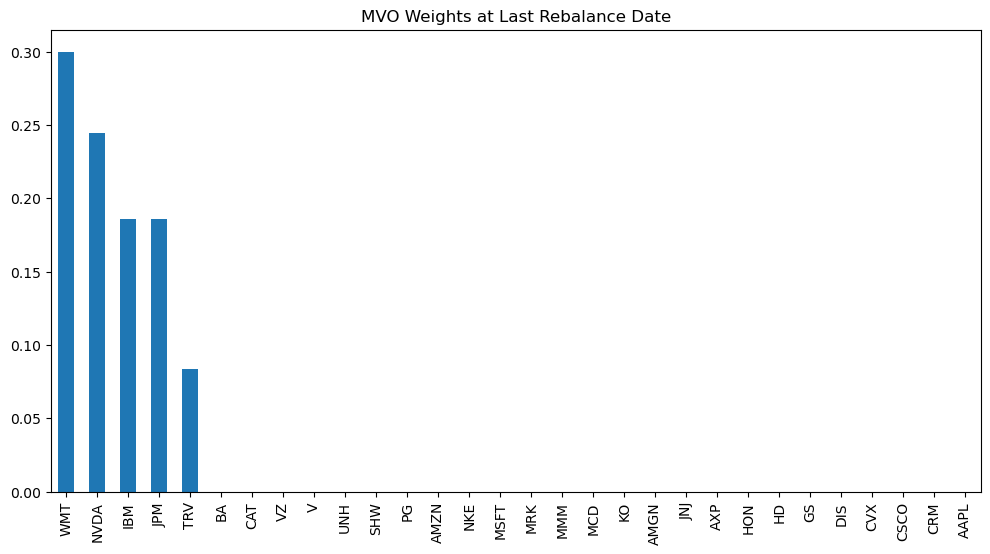

In [37]:
mvo_weights_df.iloc[-1].sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='MVO Weights at Last Rebalance Date')

### Benchmark

In [38]:
benchmark_list = ['DIA']
benchmark_data = getData(benchmark_list, startDate, endDate)
benchmark_data.fillna(method='ffill', inplace=True)

benchmark_df = pd.DataFrame(
   index=rebalance_dates,
    columns=benchmark_list,
   data=0.0
)
benchmark_df['DIA'] = 1.0


[*********************100%***********************]  1 of 1 completed


In [39]:
# Main analysis
start_date = rebalance_dates[0]  # First rebalance date

# Calculate portfolio returns for each strategy
portfolios = {
    #'Model Portfolio': model_weights_df,
    'MVO Portfolio': mvo_weights_df,
    #'Equal Weight': equal_weights_df,
    'Benchmark': benchmark_df
}

portfolio_returns = {}
for name, weights in portfolios.items():
    returns = calculate_portfolio_returns(data, weights, rebalance_dates, start_date)
    portfolio_returns[name] = returns

benchmark_returns = calculate_portfolio_returns(benchmark_data, benchmark_df, rebalance_dates, start_date)
portfolio_returns['Benchmark'] = benchmark_returns

# Calculate performance metrics
performance_metrics = {}
benchmark_returns = portfolio_returns['Benchmark']

for name, returns in portfolio_returns.items():
    if name == 'Benchmark':
        metrics = calculate_performance_metrics(returns, returns)  # Self as benchmark
    else:
        metrics = calculate_performance_metrics(returns, benchmark_returns)
    performance_metrics[name] = metrics

# Create performance comparison DataFrame
performance_df = pd.DataFrame(performance_metrics).T
print("Portfolio Performance Comparison:")
print("=" * 50)
# performance_df.to_csv(f'{output_dir}/{train_type}/performance_comparison_run{run_no}.csv')
performance_df.round(4).T

Portfolio Performance Comparison:


,MVO Portfolio,Benchmark
Total Return (%),138.9077,72.4016
Annualized Return (%),16.9981,10.3160
Volatility (%),24.5094,20.6040
Sharpe Ratio,0.6819,0.4830
Max Drawdown (%),-37.3066,-36.6956
Max Drawdown Duration (days),538.0000,477.0000
Sortino Ratio,0.8948,0.5771
Treynor Ratio,0.1785,0.0995
Jensen's Alpha (%),7.3960,-0.0071
Beta,0.9362,1.0007


In [40]:
# Plotting
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Cumulative Returns', 'Maximum Drawdown'),
    vertical_spacing=0.12,
    row_heights=[0.7, 0.3]
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot cumulative returns
for i, (name, returns) in enumerate(portfolio_returns.items()):
    #if name != 'Benchmark':
    cumulative_returns = (1 + returns).cumprod()
    fig.add_trace(
        go.Scatter(
            x=cumulative_returns.index,
            y=cumulative_returns.values,
            mode='lines',
            name=name,
            line=dict(color=colors[i], width=2),
            showlegend=True
        ),
        row=1, col=1
    )

# Plot drawdowns
for i, (name, returns) in enumerate(portfolio_returns.items()):
#if name != 'Benchmark':
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max * 100
    
    fig.add_trace(
        go.Scatter(
            x=drawdown.index,
            y=drawdown.values,
            mode='lines',
            name=name,
            line=dict(color=colors[i], width=2),
            showlegend=False
        ),
        row=2, col=1
    )

# Update layout
fig.update_layout(
    title='Portfolio Performance Comparison',
    height=800,
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Cumulative Return", row=1, col=1)
fig.update_yaxes(title_text="Drawdown (%)", row=2, col=1)

fig.show()
